In [226]:
import pandas as pd
import numpy as np
import os
import sys
import math
import random

import fasta
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import warnings
from sklearn import preprocessing
import sklearn.preprocessing
from gensim import corpora, models, similarities

import torch
import torch.nn as nn


/home/xuan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [231]:
def getWord_model(word,num_features,min_count, model, Unfile):
	word_model = ""
	if not os.path.isfile(model):
		sentence = LineSentence(Unfile,max_sentence_length = 15000)

		num_features = int(num_features)
		min_word_count = int(min_count)
		num_workers = 20
		context = 20
		downsampling = 1e-3

		print ("Training Word2Vec model...")
		word_model = Word2Vec(sentence, workers=num_workers,\
						vector_size=num_features, min_count=min_word_count, \
						window=context, sample=downsampling, seed=1)
		word_model.init_sims(replace=False)
		word_model.save(model)

	else:
		print ("Loading Word2Vec model...")
		word_model = Word2Vec.load(model)

	return word_model

def DNAToWord(dna, K):

	sentence = ""
	length = len(dna)

	for i in range(length - K + 1):
		sentence += dna[i: i + K] + " "

	sentence = sentence[0 : len(sentence) - 1]
	return sentence

In [235]:
def getDNA_split(DNAdata,word):
	list1 = []
	for DNA in DNAdata:
		DNA = str(DNA).upper()
		list1.append(DNAToWord(DNA,word).split(" "))
	return list1

def getAvgFeatureVecs(DNAdata1,model,num_features):
	counter = 0
	DNAFeatureVecs = np.zeros((len(DNAdata1),2*num_features), dtype="float32")
	
	for DNA in DNAdata1:
		if counter % 1000 == 0:
			print ("DNA %d of %d\r" % (counter, len(DNAdata1)))
			sys.stdout.flush()
		# print(DNA)
		DNAFeatureVecs[counter][0:num_features] = np.mean(model.wv[DNA],axis = 0)
		counter += 1
	# print()
	return DNAFeatureVecs


In [238]:
from sklearn.manifold import TSNE
import numpy as np
def npyTosvm(npyfile, svmfile, pos_num):
	dataDataVecs = np.load(npyfile)
	g = open(svmfile,'w')
	print(len(dataDataVecs))
	#print(dataDataVecs[0])
	m = 0
	for i in range(len(dataDataVecs)):
		line = ''
		for j in range(len(dataDataVecs[0])):
			if j == len(dataDataVecs[0])-1:
				line += str(j+1)+':'+str(dataDataVecs[i][j])+'\n'
			else:
				line += str(j+1)+':'+str(dataDataVecs[i][j])+'\t'
		m += 1
		if m < (pos_num+1):
			g.write('1\t'+line)
		else:
			g.write('0\t'+line)

def SVMtoCSV(svmfile, csvfile):
	f = open(svmfile,'r')
	g = open(csvfile,'w')
	lines = f.readlines()
	legth = len(lines[0].split('	'))-1
	#print(legth)
	classline = 'class'
	for i in range(legth):
		classline += ',%d'%(i+1)
	g.write(classline+'\n')

	for line in lines:
		line = line.strip('\n').split('	')
		g.write(line[0]+',')

		legth2 = len(line[1:])
		m = 0
		for j in line[1:]:
			if m == legth2-1:
				j = j.split(':')[-1]
				g.write(j)
				m += 1
			else:
				j = j.split(':')[-1]
				g.write(j+',')
				m += 1
		g.write('\n')

	f.close()
	g.close()


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

Embedding(64, 100)
Loading Word2Vec model...


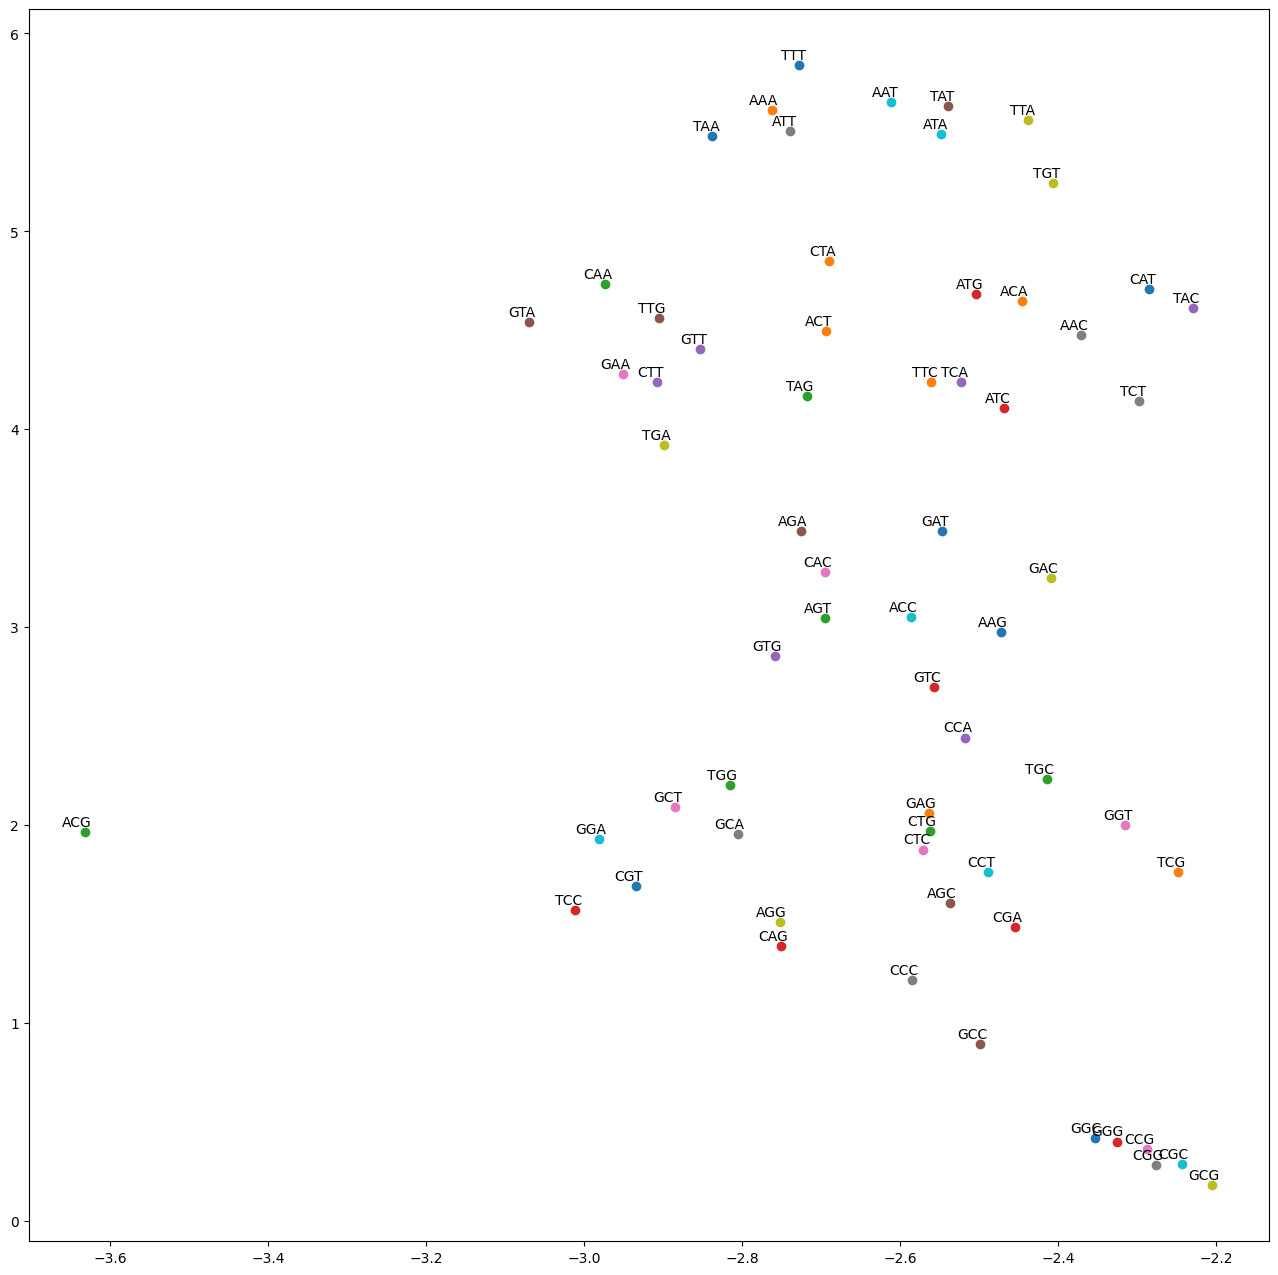

In [275]:
def kmer_tensor(input_file,k,fea_num_,min_fea_):
	kmer = k
	seq_reads = []

	for record in fasta.parse(input_file):
		seq_reads.append(str(record.seq))
	#### generate Unsupervised ##### 
	Unfile = '%dUn'%(kmer)
	g = open(Unfile,'w')
	words1 = getDNA_split(seq_reads,kmer)
	for i in range(len(words1)):
		line = ' '.join(words1[i])
		g.write(line+'\n')
	g.close()
	model = 'model_%d'%(kmer)
	fea_num = fea_num_# 100
	min_fea = min_fea_# 3
	# wm = getWord_model(kmer,fea_num,min_fea,model,Unfile)
	word_model = Word2Vec.load(model)
	weights = torch.FloatTensor(word_model.wv.vectors)
	# print(weights)
	embedding = nn.Embedding.from_pretrained(weights)
	# print(embedding)
	return embedding

# kt= kmer_tensor('test.fa',3,100,3)
# print(kt)
def plot_simlarity(k,fea_num,min_fea):
	kmer = k
	model = 'model_%d'%(kmer)
	Unfile = '%dUn'%(kmer)
	wm = getWord_model(kmer,fea_num,min_fea,model,Unfile)
	tsne_plot(wm)
# plot_simlarity(3,100,3)
# query = 'ACG'
# query_id = torch.tensor(word_model.wv['ACG'])
# gensim_vector = torch.tensor(word_model.wv[query])
# embedding_vector = embedding(query_id)
# embedding_vector
# gensim_vector
# embedding_vector
# print(gensim_vector==embedding_vector)
# tsne_plot(wm)
# dataDataVecs = getAvgFeatureVecs(words1,word_model,fea_num)
# # print (dataDataVecs)
# fea_npy = '%d_vecs.npy'%(kmer)
# np.save(fea_npy,dataDataVecs)
# words = list(wm.wv.key_to_index.keys())
# for w in words:
# 	print(w)
# print(wm.wv['ACG'])
# vocab = wm.wv.key_to_index.keys()
# for word in vocab:
#     print(wm.wv.get_index(word))
# X = model.wv[vocab]
# #### npy To csv #####
# fea_svm = '%d_vecs.svm'%(kmer)
# fea_csv = '%d_vecs.csv'%(kmer)

# npyTosvm(fea_npy, fea_svm,pos_number)
# SVMtoCSV(fea_svm, fea_csv)

